#### Summary:
This is based on my second version model interpretation notebook, modified from one Zeyang shared. It reads in the positive peak sequences (based on methods from the previous notebook) and then uses DeepLift to calculate nt importance scores for all of them. Then it has some preliminary visualization techniques. Here we are using it to repeat previous interpretation methods on my new set of models.

#### Changes from the original version:
- Combining peaks from control and AMLN sets into one peak set... use mergePeaks and then take the union; if they overlap, take the 300bp center
- Remove peaks not predicted to be positive (based on model.predict and a 0.05 threshold) --> consider if we want to standardize these by the 2 model's predictions???
- Going to considering predictions from Zeyang's IL4 model so generating importance scores from this (BUT NOT cutting down peaks based on them)

#### New Considerations - CHANGES FROM PREV V3 NOTEBOOK:
- Which peaks sets to generate importance scores from??? --> start with the same one as used previously in v2(all peaks found in BOTH datasets, then narrow down based on if the models predict them + or not)

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import compress
import numpy as np
import pandas as pd
from collections import Counter
import sys
import random
import os
import fnmatch
import sys

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from itertools import compress

In [4]:
dataDirectory = '/home/h1bennet/strains/data/ATAC/control_cohort2/'
workingDirectory = '/home/h1bennet//strains_machinelearning/results/00_New_ATAC_H3K27Ac_Model/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [5]:
os.listdir()

['bed_files',
 'model_weights',
 'poised_active_merged_peaks.txt',
 'bg_files',
 'region_scores']

# Merge active and poised peaks

In [6]:
# %%bash

# mergePeaks -d given \
# /home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/poised_enhancers/C57Bl6J_poised_enhancer_peaks.txt \
# /home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/active_enhancers/C57Bl6J_active_enhancer_peaks.txt \
# > ./poised_active_merged_peaks.txt

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing /home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/poised_enhancers/C57Bl6J_poised_enhancer_peaks.txt (37146 total) and /home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/poised_enhancers/C57Bl6J_poised_enhancer_peaks.txt (37146 total)
	Comparing /home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/poised_enhancers/C57Bl6J_poised_enhancer_peaks.txt (37146 total) and /home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/active_enhancers/C57Bl6J_active_enhancer_peaks.txt (36151 total)
	Comparing /home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/active_enhancers/C57Bl6J_active_enhancer_peaks.txt (36151 total) and /home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/poised_enhancers/C57Bl6J_poised_enhancer_peaks.txt (37146 total)
	Comparing /home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/active_enhancers/C57

# Read in the combined peak file

In [8]:
#reading in the mergePeaks file (should be the union!)
merged_peaks = pd.read_table('./poised_active_merged_peaks.txt', index_col=0)
merged_peaks.index = merged_peaks.index.rename('peakID')
merged_peaks = merged_peaks.reset_index()
merged_peaks.columns = merged_peaks.columns.str.capitalize()
print(len(merged_peaks))
merged_peaks.head()

48324


,Peakid,Chr,Start,End,Strand,Stat,Parent files,Total subpeaks,/home/h1bennet/strains/results/06_strains_control_cohort2_atac/poised_enhancers/c57bl6j_poised_enhancer_peaks.txt,/home/h1bennet/strains/results/06b_strains_control_combined_h3k27ac/active_enhancers/c57bl6j_active_enhancer_peaks.txt
0,Merged-chr5-147894194-1,chr5,147894094,147894294,+,0.0,/home/h1bennet/strains/results/06b_Strains_Con...,1,NaN,Merged-chr5-147894185-2
1,Merged-chr15-53399324-1,chr15,53399224,53399424,+,0.0,/home/h1bennet/strains/results/06b_Strains_Con...,1,NaN,Merged-chr15-53399288-3
2,Merged-chr10-95323630-1,chr10,95323530,95323730,+,0.0,/home/h1bennet/strains/results/06b_Strains_Con...,1,NaN,Merged-chr10-95323630-1
3,Merged-chr12-111743521-1,chr12,111743421,111743621,+,0.0,/home/h1bennet/strains/results/06b_Strains_Con...,1,NaN,Merged-chr12-111743523-2
4,Merged-chr11-100583077-1,chr11,100582977,100583177,+,0.0,/home/h1bennet/strains/results/06b_Strains_Con...,1,NaN,Merged-chr11-100583077-1


### Convert to a .bed file

Bed file format requires:
- chrom - name of the chromosome or scaffold. Any valid seq_region_name can be used, and chromosome names can be given with or without the 'chr' prefix.
- chromStart - Start position of the feature in standard chromosomal coordinates (i.e. first base is 0).
- chromEnd - End position of the feature in standard chromosomal coordinates

Optional columns: name, score, strand, thickStart, thickEnd, itemRgb, blockCount, blockSizes, blockStarts

from: https://m.ensembl.org/info/website/upload/bed.html

In [9]:
#just going to use the required cols (and maybe strand and score? why not, I guess)
save_cols = ['Chr', 'Start', 'End', 'Peakid', 'Stat', 'Strand']
merged_bed = merged_peaks.loc[:,save_cols]

In [10]:
merged_bed.head()

,Chr,Start,End,Peakid,Stat,Strand
0,chr5,147894094,147894294,Merged-chr5-147894194-1,0.0,+
1,chr15,53399224,53399424,Merged-chr15-53399324-1,0.0,+
2,chr10,95323530,95323730,Merged-chr10-95323630-1,0.0,+
3,chr12,111743421,111743621,Merged-chr12-111743521-1,0.0,+
4,chr11,100582977,100583177,Merged-chr11-100583077-1,0.0,+


In [11]:
print(len(merged_bed))
merged_bed.head()

48324


,Chr,Start,End,Peakid,Stat,Strand
0,chr5,147894094,147894294,Merged-chr5-147894194-1,0.0,+
1,chr15,53399224,53399424,Merged-chr15-53399324-1,0.0,+
2,chr10,95323530,95323730,Merged-chr10-95323630-1,0.0,+
3,chr12,111743421,111743621,Merged-chr12-111743521-1,0.0,+
4,chr11,100582977,100583177,Merged-chr11-100583077-1,0.0,+


In [12]:
# save this bc
save_name = "./bed_files/poised_active_merged_peaks.bed"
merged_bed.to_csv(save_name, index=False, sep="\t", header=False)

# Read sequences
Adapted from the previous notebook since we don't have fasta files for the + peaks

In [59]:
from __future__ import print_function
import numpy as np
import pandas as pd
from collections import Counter

import sys
import random

import os
import fnmatch

import sys

In [14]:
#both of these can be imported to python in the terminal in zs-deeplift env

from Bio import SeqIO
from Bio.Seq import Seq

#### Load in the mm10 genome

In [15]:
def load_genome(ref_path):
    ref_dict = {}
    for seq in SeqIO.parse(ref_path, "fasta"):
        chromID = seq.id
        chromSeq = (str(seq.seq)).upper()
        ref_dict[chromID] = chromSeq
    return ref_dict

In [16]:
ref_path = "/home/zes017/genomes/mm10/mm10.fa"
genomes = load_genome(ref_path)

#### Prepare data from a BED/peak file
Almost the correct output format! Just need one more term in the returned list for each element in this format: 'chr5_140648065_140648415_C57'

In [17]:
def data_prep(path, genomes, label, strain, size=500, rep=1, shift=None):
    print ("Scaled to %d" % (size))
    if shift is None:
        shifts = size//rep*np.arange(-rep//2+1,rep//2+1)
    elif type(shift) is int:
        shifts = np.abs(shift)*np.arange(-rep//2+1,rep//2+1)
    elif type(shift) is list:
        if len(shift) != rep:
            raise TypeError("Number of shift unequal to replicates")
        shifts = np.array(shift)
    if rep == 1 and shift is not None:
        random_shift = True
        print("Random shifting within %s" % (str(-np.abs(shift))+'~'+str(np.abs(shift))))
    else:
        random_shift = False
        print("Generate replicates by shifting %s bp" % (','.join(shifts.astype(str))))
    
    data_list = []
    for line in open(path):
        elems = line.split()
        chromID = elems[0]
        start, end = int(elems[1]), int(elems[2])
        length = end-start
        mid = (start+end)//2
        for s in shifts:
            if random_shift:
                new_mid = mid + np.random.choice(np.arange(-np.abs(shift), np.abs(shift)+1))
            else:
                new_mid = mid + s
            start = new_mid - size//2
            end = new_mid + size//2
            seq = genomes[chromID][start:end]
            if len(seq) != size:
                continue
                
            #created combined name term, ex: chr5_140648065_140648415_C57
            k = chromID + "_" + str(start) + "_" + str(end) + "_" + strain

            data_point = (seq, label, chromID, start, end, k)
            data_list.append(data_point)
    return data_list

In [18]:
#control --> delete first col!
data_path = "./bed_files/poised_active_merged_peaks.bed"
orig_data = data_prep(data_path, genomes, 1, "C57", size=300, rep=1, shift=None)
print(len(orig_data))

Scaled to 300
Generate replicates by shifting 0 bp
48324


In [19]:
print(orig_data[0])

('TCTATTGCAGAGCGGGAAGCGGGAGGAGAGAAACGGGGCGAGTGTGGGGGGGGGGGATAGAAATCATCAGTTGATTTTTTATCCCAGAGGCTAAATTCTCAAAAGTGGGGAAGTTGGAACAATGTGTCATAAACAAACATTAGCAAGCAAAAAGAGTTCCAGATTTCTGAGAGAGTGCCCTTGCCGGGAGAGGGTACCCTAGTTCTCTCCGAGGAGCAGGGACTAAGTCAACCTCCGCCCCCGACTCCGCTTAGCTAATGCTCACAGTGCTGAGCAGAACAGCACCGGCCGGTTCCCATA', 1, 'chr5', 147894044, 147894344, 'chr5_147894044_147894344_C57')


# Convert to one hot encode sequences

In [20]:
import random
from Bio import Seq

def dataset2onehot(dataset, shuffle=True):
    nucleotides = ["A", "T", "C", "G"]
    def seq2onehot(seq):
        onehot_list = []
        for nuc in seq:
            if nuc == "N":
                onehot = [0.25 for _ in range(len(nucleotides))]
                onehot_list.append(onehot)
            else:
                onehot = [0 for _ in range(len(nucleotides))]
                onehot[nucleotides.index(nuc)] = 1
                onehot_list.append(onehot)
        return onehot_list
    
    def rc(seq):
        return str((Seq.Seq(seq)).reverse_complement())
    
    onehot_dataset = []
    for (seq, label, chromID, start, end, ID) in dataset:
        onehot_dataset.append((seq2onehot(seq), label, (chromID, start, end, "+")))
        onehot_dataset.append((seq2onehot(rc(seq)), label, (chromID, start, end, "-")))
    
    if shuffle:
        random.shuffle(onehot_dataset)
    
    x_list, y_list, info_list = [], [], [] 
    for (x, y, info) in onehot_dataset:
        x_list.append(x)
        y_list.append(y)
        info_list.append(info)
    return np.array(x_list), np.array(y_list), info_list

In [21]:
x_vis, y_vis, info_vis = dataset2onehot(orig_data, False) #combined!

In [22]:
print(x_vis.shape)
print(y_vis.shape)

(96648, 300, 4)
(96648,)


In [23]:
print(len(orig_data))

48324


# Filter data for positive peaks

In [24]:
#need to import the model first!
import keras
from keras.models import model_from_json

Using TensorFlow backend.


## Poised model

In [69]:
#homeostatic model first
keras_model_weights = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_poised_epo20_RandomShift0bp.h5"
keras_model_json = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_poised_epo20_RandomShift0bp.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)
keras_model.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])

In [70]:
peak_preds = keras_model.predict(x_vis).flatten()

96648
71270


(array([ 4370.,  6005.,  5089.,  5043.,  4871.,  4960.,  6145.,  8077.,
        14524., 37564.]),
 array([4.5299530e-06, 1.0000408e-01, 2.0000362e-01, 3.0000317e-01,
        4.0000272e-01, 5.0000226e-01, 6.0000181e-01, 7.0000136e-01,
        8.0000091e-01, 9.0000045e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

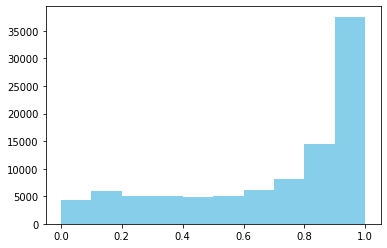

In [71]:
print(len(peak_preds))
print(sum(i > 0.5 for i in peak_preds))
plt.hist(peak_preds,color='skyblue')

## Active Model

In [72]:
#differential model second
keras_model_weights2 = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_active_epo20_RandomShift0bp.h5"
keras_model_json2 = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_active_epo20_RandomShift0bp.json"

keras_model2 = model_from_json(open(keras_model_json2).read())
keras_model2.load_weights(keras_model_weights2)
keras_model2.compile(loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(lr=1e-2),
        metrics=['accuracy'])

In [73]:
peak_preds2 = keras_model2.predict(x_vis).flatten()

96648
83338


(array([  342.,  2043.,  4074.,  3354.,  3497.,  4312.,  9310., 12650.,
        21537., 35529.]),
 array([4.47034836e-07, 1.00000404e-01, 2.00000361e-01, 3.00000310e-01,
        4.00000274e-01, 5.00000238e-01, 6.00000203e-01, 7.00000107e-01,
        8.00000072e-01, 9.00000036e-01, 1.00000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

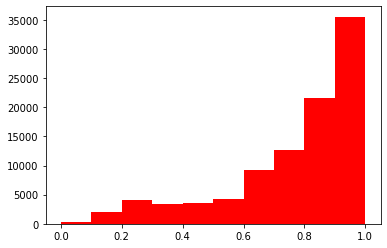

In [74]:
print(len(peak_preds2))
print(sum(i > 0.5 for i in peak_preds2))
plt.hist(peak_preds2,color='red')

# Cutting down the data lists

### Keep seqs where at least one of preds for (seq and rc) is above threshold

In [75]:
#easiest thing is to just put both in the df then can be modular about cutting this down
poised_preds = peak_preds[::2]
poised_preds_rc = peak_preds[1::2]
active_preds = peak_preds2[::2]
active_preds_rc = peak_preds2[1::2]

In [76]:
merged_bed["Poised Predictions"] = poised_preds
merged_bed["Poised Predictions RC"] = poised_preds_rc
merged_bed["Active Predictions"] = active_preds
merged_bed["Active Predictions RC"] = active_preds_rc

In [77]:
print(len(merged_bed))
merged_bed.head()

48324


,Chr,Start,End,Peakid,Stat,Strand,Poised Predictions,Poised Predictions RC,Active Predictions,Active Predictions RC
0,chr5,147894094,147894294,Merged-chr5-147894194-1,0.0,+,0.850177,0.580634,0.930514,0.886086
1,chr15,53399224,53399424,Merged-chr15-53399324-1,0.0,+,0.843508,0.767881,0.864703,0.922945
2,chr10,95323530,95323730,Merged-chr10-95323630-1,0.0,+,0.168567,0.238811,0.625731,0.631909
3,chr12,111743421,111743621,Merged-chr12-111743521-1,0.0,+,0.922834,0.916620,0.924718,0.895533
4,chr11,100582977,100583177,Merged-chr11-100583077-1,0.0,+,0.938389,0.930212,0.939787,0.963610


In [78]:
save_name = "./bed_files/poised_active_merged_peaks_scored.bed"
merged_bed.to_csv(save_name, index=False, header=True, sep="\t")

## Cut down bed df and then remake the dataset

In [79]:
merged_bed.shape

(48324, 10)

### Poised model predicts positive

In [80]:
#first cut (just take a row if one passes)
save_rows1 = []
for row in merged_bed.iterrows():
    if row[1].loc['Poised Predictions'] > 0.5 or row[1].loc['Poised Predictions RC'] > 0.5:
        save_rows1.append(row[0])
        
print(len(save_rows1))

38482


In [81]:
merged_bed_filter = merged_bed.iloc[save_rows1,:]
print(len(merged_bed_filter))
merged_bed_filter.head()

38482


,Chr,Start,End,Peakid,Stat,Strand,Poised Predictions,Poised Predictions RC,Active Predictions,Active Predictions RC
0,chr5,147894094,147894294,Merged-chr5-147894194-1,0.0,+,0.850177,0.580634,0.930514,0.886086
1,chr15,53399224,53399424,Merged-chr15-53399324-1,0.0,+,0.843508,0.767881,0.864703,0.922945
3,chr12,111743421,111743621,Merged-chr12-111743521-1,0.0,+,0.922834,0.916620,0.924718,0.895533
4,chr11,100582977,100583177,Merged-chr11-100583077-1,0.0,+,0.938389,0.930212,0.939787,0.963610
5,chr11,98782374,98782574,Merged-chr11-98782474-1,0.0,+,0.059996,0.648414,0.830570,0.707561


In [82]:
save_name = "./bed_files/poised_active_merged_peaks_scored_poised_filtered.bed"
merged_bed_filter.to_csv(save_name, index=False, header=False, sep="\t")

### Active model predicts positive

In [83]:
#first cut (just take a row if one passes)
save_rows2 = []
for row in merged_bed.iterrows():
    if row[1].loc['Active Predictions'] > 0.5 or row[1].loc['Active Predictions RC'] > 0.5:
        save_rows2.append(row[0])
        
print(len(save_rows2))

43537


In [84]:
merged_bed_filter_active = merged_bed.iloc[save_rows2,:]
print(len(merged_bed_filter_active))
merged_bed_filter_active.head()

43537


,Chr,Start,End,Peakid,Stat,Strand,Poised Predictions,Poised Predictions RC,Active Predictions,Active Predictions RC
0,chr5,147894094,147894294,Merged-chr5-147894194-1,0.0,+,0.850177,0.580634,0.930514,0.886086
1,chr15,53399224,53399424,Merged-chr15-53399324-1,0.0,+,0.843508,0.767881,0.864703,0.922945
2,chr10,95323530,95323730,Merged-chr10-95323630-1,0.0,+,0.168567,0.238811,0.625731,0.631909
3,chr12,111743421,111743621,Merged-chr12-111743521-1,0.0,+,0.922834,0.916620,0.924718,0.895533
4,chr11,100582977,100583177,Merged-chr11-100583077-1,0.0,+,0.938389,0.930212,0.939787,0.963610


In [85]:
save_name = "./bed_files/poised_active_merged_peaks_scored_active_filtered.bed"
merged_bed_filter_active.to_csv(save_name, index=False, header=False, sep="\t")

### Both active and poised

In [86]:
#first cut (just take a row if one passes)
save_rows3 = []
for row in merged_bed.iterrows():
    if row[1].loc['Poised Predictions'] > 0.5 or row[1].loc['Poised Predictions RC'] > 0.5:
        if row[1].loc['Active Predictions'] > 0.5 or row[1].loc['Active Predictions RC'] > 0.5:
            save_rows3.append(row[0])
        
print(len(save_rows3))

37452


In [87]:
merged_bed_filter_both = merged_bed.iloc[save_rows3,:]
print(len(merged_bed_filter_both))
merged_bed_filter_both.head()

37452


,Chr,Start,End,Peakid,Stat,Strand,Poised Predictions,Poised Predictions RC,Active Predictions,Active Predictions RC
0,chr5,147894094,147894294,Merged-chr5-147894194-1,0.0,+,0.850177,0.580634,0.930514,0.886086
1,chr15,53399224,53399424,Merged-chr15-53399324-1,0.0,+,0.843508,0.767881,0.864703,0.922945
3,chr12,111743421,111743621,Merged-chr12-111743521-1,0.0,+,0.922834,0.916620,0.924718,0.895533
4,chr11,100582977,100583177,Merged-chr11-100583077-1,0.0,+,0.938389,0.930212,0.939787,0.963610
5,chr11,98782374,98782574,Merged-chr11-98782474-1,0.0,+,0.059996,0.648414,0.830570,0.707561


In [88]:
save_name = "./bed_files/poised_active_merged_peaks_scored_poised_active_filtered.bed"
merged_bed_filter_both.to_csv(save_name, index=False, header=False, sep="\t")

## Now remake the datasets

In [89]:
#poised --> delete first col!
data_path = "./bed_files/poised_active_merged_peaks_scored_poised_filtered.bed"
poised_pos_data = data_prep(data_path, genomes, 1, "C57", size=300, rep=1, shift=None)
print(len(poised_pos_data))

Scaled to 300
Generate replicates by shifting 0 bp
38482


In [90]:
#amln+ --> delete first col!
data_path = "./bed_files/poised_active_merged_peaks_scored_active_filtered.bed"
active_pos_data = data_prep(data_path, genomes, 1, "C57", size=300, rep=1, shift=None)
print(len(active_pos_data))

Scaled to 300
Generate replicates by shifting 0 bp
43537


In [91]:
#amln+ AND control+ --> delete first col!
data_path = "./bed_files/poised_active_merged_peaks_scored_poised_active_filtered.bed"
both_pos_data = data_prep(data_path, genomes, 1, "C57", size=300, rep=1, shift=None)
print(len(both_pos_data))

Scaled to 300
Generate replicates by shifting 0 bp
37452


# Score nucleotide importance with DeepLIFT
## Do this twice for each model... the overlap set and the individual set

In [92]:
import deeplift
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
from collections import OrderedDict
from deeplift.util import get_shuffle_seq_ref_function
from deeplift.dinuc_shuffle import dinuc_shuffle

## Define scoring function

In [93]:
#control model
#already compiled... making new one here that I'm not compiling
keras_model_weights = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_poised_epo20_RandomShift0bp.h5"
keras_model_json = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_poised_epo20_RandomShift0bp.json"

keras_model1 = model_from_json(open(keras_model_json).read())
keras_model1.load_weights(keras_model_weights)

#new to run
nonlinear_mxts_mode = NonlinearMxtsMode.DeepLIFT_GenomicsDefault
deeplift_method = kc.convert_model_from_saved_files(
            h5_file=keras_model_weights,
            json_file=keras_model_json,
            nonlinear_mxts_mode=nonlinear_mxts_mode)
scoring_func = deeplift_method.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 2 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 7 the preceding linear layer is 5 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 12 the preceding linear layer is 10 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 16 the preceding linear layer is 15 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume sigm

# Need to rerun this one too!

In [94]:
#control model
#already compiled... making new one here that I'm not compiling
keras_model_weights2 = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_active_epo20_RandomShift0bp.h5"
keras_model_json2 = workingDirectory+"/model_weights/modelWeights_300bp_C57BL6J_active_epo20_RandomShift0bp.json"

keras_model2 = model_from_json(open(keras_model_json2).read())
keras_model2.load_weights(keras_model_weights2)

#new to run
nonlinear_mxts_mode = NonlinearMxtsMode.DeepLIFT_GenomicsDefault
deeplift_method2 = kc.convert_model_from_saved_files(
            h5_file=keras_model_weights2,
            json_file=keras_model_json2,
            nonlinear_mxts_mode=nonlinear_mxts_mode)
scoring_func2 = deeplift_method2.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 2 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 7 the preceding linear layer is 5 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 12 the preceding linear layer is 10 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 16 the preceding linear layer is 15 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume sigm

## Specify reference and compute importance

In [95]:
len(both_pos_data)

37452

In [96]:
len(active_pos_data)

43537

In [97]:
len(poised_pos_data)

38482

In [98]:
#making 3 onehotseqs from all 3 pos data sets
x_vis_poised, y_vis_poised, info_vis_poised = dataset2onehot(poised_pos_data, False)
x_vis_active, y_vis_active, info_vis_active = dataset2onehot(active_pos_data, False)
x_vis_both, y_vis_both, info_vis_both = dataset2onehot(both_pos_data, False)

In [99]:
print(x_vis_poised.shape)
print(y_vis_poised.shape)
print(x_vis_active.shape)
print(y_vis_active.shape)
print(x_vis_both.shape)
print(y_vis_both.shape)

(76964, 300, 4)
(76964,)
(87074, 300, 4)
(87074,)
(74904, 300, 4)
(74904,)


### Poised model 
- Scores 1 = poised pos data
- Scores 2 = active + poised pos data

In [113]:
%%time
batch_size = 128
background = OrderedDict([('A', 0.25), ('C', 0.25), ('G', 0.25), ('T', 0.25)])
scores1 = np.array(scoring_func(task_idx=0, input_data_list=[x_vis_poised], batch_size=batch_size, 
                               input_references_list=[np.array([background['A'], 
                                                                background['C'], 
                                                                background['G'], 
                                                                background['T']])[None,None,:]],
                               progress_update=1000))
scores1 = np.sum(scores1, axis=2)

Done 0
Done 16000
Done 32000
Done 48000
Done 64000
CPU times: user 2h 57min 16s, sys: 18min 43s, total: 3h 16min
Wall time: 5min 48s


In [100]:
%%time
batch_size = 128 
background = OrderedDict([('A', 0.25), ('C', 0.25), ('G', 0.25), ('T', 0.25)])
scores2 = np.array(scoring_func(task_idx=0, input_data_list=[x_vis_both], batch_size=batch_size, 
                               input_references_list=[np.array([background['A'], 
                                                                background['C'], 
                                                                background['G'], 
                                                                background['T']])[None,None,:]],
                               progress_update=1000))
scores2 = np.sum(scores2, axis=2)

Done 0
Done 16000
Done 32000
Done 48000
Done 64000
CPU times: user 2h 48min 32s, sys: 16min 50s, total: 3h 5min 23s
Wall time: 6min 9s


### Active model
- Scores 3 = active pos data
- Scores 4 = active + poised pos data

In [101]:
%%time
batch_size = 128 
background = OrderedDict([('A', 0.25), ('C', 0.25), ('G', 0.25), ('T', 0.25)])
scores3 = np.array(scoring_func2(task_idx=0, input_data_list=[x_vis_active], batch_size=batch_size, 
                               input_references_list=[np.array([background['A'], 
                                                                background['C'], 
                                                                background['G'], 
                                                                background['T']])[None,None,:]],
                               progress_update=1000))
scores3 = np.sum(scores3, axis=2)

Done 0
Done 16000
Done 32000
Done 48000
Done 64000
Done 80000
CPU times: user 3h 15min 3s, sys: 20min 34s, total: 3h 35min 38s
Wall time: 7min 24s


In [102]:
%%time
batch_size = 128 
background = OrderedDict([('A', 0.25), ('C', 0.25), ('G', 0.25), ('T', 0.25)])
scores4 = np.array(scoring_func2(task_idx=0, input_data_list=[x_vis_both], batch_size=batch_size, 
                               input_references_list=[np.array([background['A'], 
                                                                background['C'], 
                                                                background['G'], 
                                                                background['T']])[None,None,:]],
                               progress_update=1000))
scores4 = np.sum(scores4, axis=2)

Done 0
Done 16000
Done 32000
Done 48000
Done 64000
CPU times: user 2h 46min 50s, sys: 16min 29s, total: 3h 3min 19s
Wall time: 6min 9s


## Get nucleotide-level max importance from original and reverse compliment sequences

### Select peak names
As an edit to Hannah's code I want to also propagate the peak id feature so that I can easily match with differential sequences from our analysis

In [103]:
merged_bed_filter.head()

,Chr,Start,End,Peakid,Stat,Strand,Poised Predictions,Poised Predictions RC,Active Predictions,Active Predictions RC
0,chr5,147894094,147894294,Merged-chr5-147894194-1,0.0,+,0.850177,0.580634,0.930514,0.886086
1,chr15,53399224,53399424,Merged-chr15-53399324-1,0.0,+,0.843508,0.767881,0.864703,0.922945
3,chr12,111743421,111743621,Merged-chr12-111743521-1,0.0,+,0.922834,0.916620,0.924718,0.895533
4,chr11,100582977,100583177,Merged-chr11-100583077-1,0.0,+,0.938389,0.930212,0.939787,0.963610
5,chr11,98782374,98782574,Merged-chr11-98782474-1,0.0,+,0.059996,0.648414,0.830570,0.707561


In [104]:
merged_bed_filter_active.head()

,Chr,Start,End,Peakid,Stat,Strand,Poised Predictions,Poised Predictions RC,Active Predictions,Active Predictions RC
0,chr5,147894094,147894294,Merged-chr5-147894194-1,0.0,+,0.850177,0.580634,0.930514,0.886086
1,chr15,53399224,53399424,Merged-chr15-53399324-1,0.0,+,0.843508,0.767881,0.864703,0.922945
2,chr10,95323530,95323730,Merged-chr10-95323630-1,0.0,+,0.168567,0.238811,0.625731,0.631909
3,chr12,111743421,111743621,Merged-chr12-111743521-1,0.0,+,0.922834,0.916620,0.924718,0.895533
4,chr11,100582977,100583177,Merged-chr11-100583077-1,0.0,+,0.938389,0.930212,0.939787,0.963610


In [105]:
merged_bed_filter_both.head()

,Chr,Start,End,Peakid,Stat,Strand,Poised Predictions,Poised Predictions RC,Active Predictions,Active Predictions RC
0,chr5,147894094,147894294,Merged-chr5-147894194-1,0.0,+,0.850177,0.580634,0.930514,0.886086
1,chr15,53399224,53399424,Merged-chr15-53399324-1,0.0,+,0.843508,0.767881,0.864703,0.922945
3,chr12,111743421,111743621,Merged-chr12-111743521-1,0.0,+,0.922834,0.916620,0.924718,0.895533
4,chr11,100582977,100583177,Merged-chr11-100583077-1,0.0,+,0.938389,0.930212,0.939787,0.963610
5,chr11,98782374,98782574,Merged-chr11-98782474-1,0.0,+,0.059996,0.648414,0.830570,0.707561


In [191]:
#building an index for use in all, peak_ids (chr_start_end)
#bed_df_both.head()

peak_ids_poised = []
merge_ids_poised = merged_bed_filter['Peakid'].tolist()
for row in range(len(merged_bed_filter)):
    peak = str(merged_bed_filter.iloc[row,0]) + "_" + str(merged_bed_filter.iloc[row,1]) + "_" + str(merged_bed_filter.iloc[row,2])
    peak_ids_poised.append(peak)

In [106]:
#building an index for use in all, peak_ids (chr_start_end)
#bed_df_both.head()

peak_ids_active = []
merge_ids_active = merged_bed_filter_active['Peakid'].tolist()

for row in range(len(merged_bed_filter_active)):
    peak = str(merged_bed_filter_active.iloc[row,0]) + "_" + str(merged_bed_filter_active.iloc[row,1]) + "_" + str(merged_bed_filter_active.iloc[row,2])
    peak_ids_active.append(peak)

In [107]:
#building an index for use in all, peak_ids (chr_start_end)
#merged_bed_filter_both.head()

peak_ids_both = []
merge_ids_both = merged_bed_filter_both['Peakid'].tolist()
for row in range(len(merged_bed_filter_both)):
    peak = str(merged_bed_filter_both.iloc[row,0]) + "_" + str(merged_bed_filter_both.iloc[row,1]) + "_" + str(merged_bed_filter_both.iloc[row,2])
    peak_ids_both.append(peak)

In [110]:
# print(len(peak_ids_poised))
# print(peak_ids_poised[:5])
# print(merge_ids_poised[:5])
print(len(peak_ids_active))
print(peak_ids_active[:5])
print(len(peak_ids_both))
print(peak_ids_both[:5])

43537
['chr5_147894094_147894294', 'chr15_53399224_53399424', 'chr10_95323530_95323730', 'chr12_111743421_111743621', 'chr11_100582977_100583177']
37452
['chr5_147894094_147894294', 'chr15_53399224_53399424', 'chr12_111743421_111743621', 'chr11_100582977_100583177', 'chr11_98782374_98782574']


# Write out scores

In [111]:
if not os.path.isdir('./region_scores/'):
    os.mkdir('./region_scores/')

##  Poised Model
- Scores 1 = poised pos data
- Scores 2 = active pos data

### Poised model, poised data

In [138]:
weights1 = []
for sample_index in range(len(scores1)//2):
    sample_scores1 = np.array([scores1[sample_index*2], scores1[sample_index*2+1][::-1]])
    sample_score1 = np.array([sample_scores1[j,i] for i,j in enumerate(np.argmax(np.absolute(sample_scores1), axis=0))])
    weights1.append(sample_score1)
weights1 = np.array(weights1)
weights1.shape

(38482, 300)

In [197]:
#writing this to a file so can use in other notebooks
#want to include some sort of index here too... maybe peak IDs?

control_nt_weights1 = "./region_scores/poised_model_poised_peak_weights.txt"
weights_df1 = pd.DataFrame(weights1)
weights_df1.index = peak_ids_poised
print(weights_df1.shape)
#control_weights_df.head()
weights_df1.to_csv(control_nt_weights1,index = True, sep='\t')

(38482, 300)


### Poised model, both data

In [112]:
weights2 = []
for sample_index in range(len(scores2)//2):
    sample_scores2 = np.array([scores2[sample_index*2], scores2[sample_index*2+1][::-1]])
    sample_score2 = np.array([sample_scores2[j,i] for i,j in enumerate(np.argmax(np.absolute(sample_scores2), axis=0))])
    weights2.append(sample_score2)
weights2 = np.array(weights2)
weights2.shape

(37452, 300)

In [114]:
#writing this to a file so can use in other notebooks
#want to include some sort of index here too... maybe peak IDs?

control_nt_weights2 = "./region_scores/poised_model_poised_active_peak_weights.txt"
weights_df2 = pd.DataFrame(weights2)
weights_df2.index = peak_ids_both
print(weights_df2.shape)
#control_weights_df.head()
weights_df2.to_csv(control_nt_weights2,index = True, sep='\t')

(37452, 300)


## Active model
- Scores 3 = Active pos data
- Scores 4 = Active pos data

### Active model, Active positional data

In [115]:
weights3 = []
for sample_index in range(len(scores3)//2):
    sample_scores3 = np.array([scores3[sample_index*2], scores3[sample_index*2+1][::-1]])
    sample_score3 = np.array([sample_scores3[j,i] for i,j in enumerate(np.argmax(np.absolute(sample_scores3), axis=0))])
    weights3.append(sample_score3)
weights3 = np.array(weights3)
weights3.shape

(43537, 300)

In [116]:
#writing this to a file so can use in other notebooks
#want to include some sort of index here too... maybe peak IDs?

diff_nt_weights3 = "./region_scores/active_model_active_peak_weights.txt"
weights_df3 = pd.DataFrame(weights3)
weights_df3.index = peak_ids_active
print(weights_df3.shape)
#control_weights_df.head()
weights_df3.to_csv(diff_nt_weights3,index = True, sep='\t')

(43537, 300)


### Active model, active + poised positional data

In [118]:
weights4 = []
for sample_index in range(len(scores4)//2):
    sample_scores4 = np.array([scores4[sample_index*2], scores4[sample_index*2+1][::-1]])
    sample_score4 = np.array([sample_scores4[j,i] for i,j in enumerate(np.argmax(np.absolute(sample_scores4), axis=0))])
    weights4.append(sample_score4)
weights4 = np.array(weights4)
weights4.shape

(37452, 300)

In [120]:
#writing this to a file so can use in other notebooks
#want to include some sort of index here too... maybe peak IDs?

diff_nt_weights4 = "./region_scores/active_model_active_poised_peak_weights.txt"
weights_df4 = pd.DataFrame(weights4)
weights_df4.index = peak_ids_both
print(weights_df4.shape)
# control_weights_df.head()
weights_df4.to_csv(diff_nt_weights4,index = True, sep='\t')

(37452, 300)


### Smooth Weights

In [198]:
proc_range = 1
smooth_weights1 = np.array([[np.mean(np.abs(w[max(0, i-proc_range):min(len(w), i+proc_range+1)]))
                         for i in range(len(w))] for w in weights1])
print(smooth_weights1.shape)

(38482, 300)


In [121]:
proc_range = 1
smooth_weights2 = np.array([[np.mean(np.abs(w[max(0, i-proc_range):min(len(w), i+proc_range+1)]))
                         for i in range(len(w))] for w in weights2])
print(smooth_weights2.shape)

(37452, 300)


In [122]:
proc_range = 1
smooth_weights3 = np.array([[np.mean(np.abs(w[max(0, i-proc_range):min(len(w), i+proc_range+1)]))
                         for i in range(len(w))] for w in weights3])
print(smooth_weights3.shape)

(43537, 300)


In [123]:
proc_range = 1
smooth_weights4 = np.array([[np.mean(np.abs(w[max(0, i-proc_range):min(len(w), i+proc_range+1)]))
                         for i in range(len(w))] for w in weights4])
print(smooth_weights4.shape)

(37452, 300)


# Visualize importance scores for individual site

For now we will just use score1 and score3 since they are the ones that were properly trained.

In [200]:
# active_pos_data[0]

In [182]:
# both_pos_data[0]

In [212]:
s = 'chr5_147894044_147894344_C57'
s2 = 'chr19_17276031_17276331_C57'

sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(17,3.2))
w = np.abs(smooth_weights1[np.array(poised_pos_data)[:,-1] == s2][0])
plt.scatter(np.arange(len(w)), w, s=10, c='#3A90E3',zorder=10)
plt.axhline(np.sort(w)[240], c='orangered', linestyle='--', linewidth=3)
plt.xlim(0,300)
plt.xlabel('position')
plt.ylabel('abs. DeepLIFT score')
sns.despine(top=True, bottom=True)
plt.tight_layout()

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1224x230.4 with 0 Axes>

In [213]:
# s = 'chr5_147894044_147894344_C57'

# sns.set(style='white', font_scale=1.5)
# plt.figure(figsize=(17,3.2))
# w = np.abs(smooth_weights3[np.array(active_pos_data)[:,-1] == s][0])
# plt.scatter(np.arange(len(w)), w, s=10, c='#3A90E3',zorder=10)
# plt.axhline(np.sort(w)[240], c='orangered', linestyle='--', linewidth=3)
# plt.xlim(0,300)
# plt.xlabel('position')
# plt.ylabel('abs. DeepLIFT score')
# sns.despine(top=True, bottom=True)
# plt.tight_layout()